In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Projet 2 - Modèles épidémiologiques


### 1) Modelisation système SIR

Le modèle SIR est un modele qui décrit la propagation d'un virus (biologique ou informatique) au sein d'une population homogène. Il divise la population en trois catégories : les susceptibles (S), les infectés (I) et les retirés (R). Les parametes importants sont: le taux de transmission $\beta$ et le taux de guérison $\gamma$.

### Équations du Modèle

Dans le modele SIR, comme vue en cours et dans le poly,les equations sont données par :

$$
S(t)+I(t) +R(t) = N+1
$$

$$
\frac{dS(t)}{dt} = -\beta S(t) I(t),
$$

$$
\frac{dI(t)}{dt} = \beta S(t) I(t) - \gamma I(t),
$$

$$
\frac{dR(t)}{dt} = \gamma I(t),
$$

tel que la population est de taille $N+1$,


Pour simuler ce système, comme en TSE101 dans la partie Lotka Volterra, j'ai utilisé la méthode d'Euler. À chaque itération, les valeurs de $S$, $I$ et $R$ sont mises à jour en fonction des taux de variation calculés.

Voici la fonction qui simule le modèle :

In [87]:
def sir_model(N_pop, beta, gamma, tps_model, dt):
    S = [N_pop]
    I = [1]
    R = [0]
    t = [0]
    
    # Simulation via methode de Euler
    while t[-1] < tps_model:
        #Met a jour chaque valeur de S,I,R avec l'instant n-1
        dS = -beta * S[-1] * I[-1] / N_pop
        dI = beta * S[-1] * I[-1] / N_pop - gamma * I[-1]
        dR = gamma * I[-1]
        
        #Ajoute toutes les valeurs mise a jour en n + n-1
        S.append(S[-1] + dS * dt)
        I.append(I[-1] + dI * dt)
        R.append(R[-1] + dR * dt)
        t.append(t[-1] + dt)
    
    return np.array(t), np.array(S), np.array(I), np.array(R)

Voici le code qui affiche les résultats pour des paramètres de $\gamma = 10\%$, $\beta = 20\%$, $N = 10^3$. (J'ai pris les meme parametres que [1])

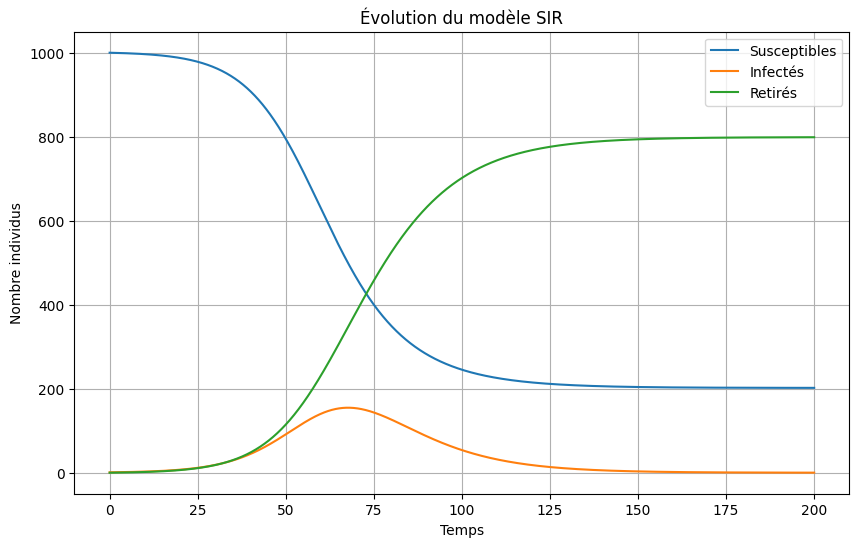

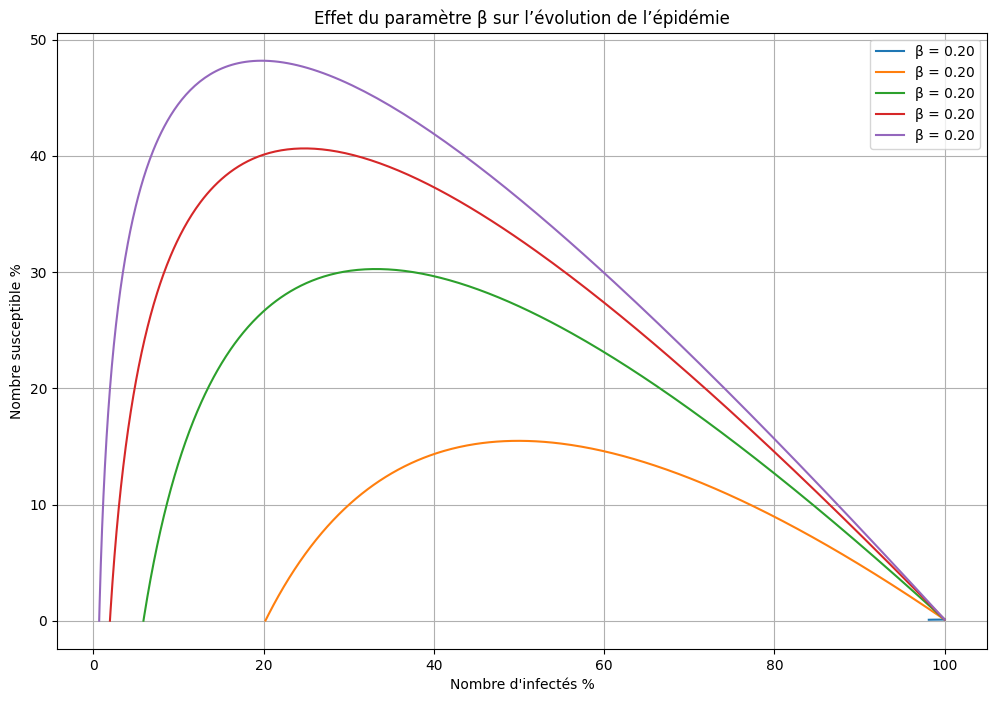

In [ ]:
#Parametre de la simulation
N_pop = 1000      # Valeurs conseiller en cours
beta = 0.2    # 20%
gamma = 0.1   # 10%
tps_model = 200 
dt = 0.1   

t, S, I, R = sir_model(N_pop, beta, gamma, tps_model, dt)

# Plot du graph
plt.figure(figsize=(10,6))
plt.plot(t, S, label='Susceptibles')
plt.plot(t, I, label='Infectés')
plt.plot(t, R, label='Retirés')
plt.xlabel('Temps')
plt.ylabel('Nombre individus')
plt.title('Évolution du modèle SIR')
plt.legend()
plt.grid()
plt.show()

#Je veux voir l'impacte de beta sur la propagation
effet_beta = []
beta_val = np.linspace(0.1, 0.5, 5)

#Boucle sur les valeurs de beta
for i in beta_val:
    t, S, I, R = sir_model(N_pop, i, gamma, tps_model, dt)
    effet_beta.append((beta, t, S, I, R))

#Plot des graphs
plt.figure(figsize=(12,8))
for beta, t, S, I, R in effet_beta:
    plt.plot((S/N_pop)*100, (I/N_pop)*100, label=f"β = {beta:.2f}")
plt.xlabel('Nombre d\'infectés %')
plt.ylabel('Nombre susceptible %')
plt.title('Effet du paramètre β sur l’évolution de l’épidémie')
plt.legend()
plt.grid()
plt.show()




### 2) Modelisation du processus de Markov

Dans ca cas $\beta$ devient le taux de rencontres que ce soit avec des susceptibles, des infectés ou des retirés pour une population de N individus<br>
Et on note $X = (S, I, R)$  un processus de Markov tel que :

- $(s,i,r) \rightarrow (s-1,i+1,r)$ au taux $\beta N^{-1} is \mathbb{1}_{s>0}$
- $(s,i,r) \rightarrow (s,i-1,r+1)$ au taux $\gamma i \mathbb{1}_{i>0}$

On note ausse $R_0 = \frac{\beta}{\gamma}$.

La probabilité que le prochain événement soit une infection est donc :
$$
\frac{\beta \frac{SI}{N}}{\beta \frac{SI}{N} + \gamma I}
$$
et la probabilité qu'il s'agisse d'une sortie (guérison) est :
$$
\frac{\gamma I}{\beta \frac{SI}{N} + \gamma I}
$$

Le temps entre deux événements suit une loi exponentielle de paramètre égal au taux total :
$$
\text{Temps entre événements} \sim \text{Exp}(\text{Taux total})
$$
La simulation s'arrête dès que $I(t) = 0$ (plus d'infectés)


In [ ]:
# Fonction pour obtenir les taux en fonction de l'état actuel
def etat_suivant(S, I, R, N, beta, gamma):
    taux_infection = beta * S * I / N if S > 0 else 0
    taux_sortie = gamma * I if I > 0 else 0
    return taux_infection, taux_sortie

# Fonction pour faire une transition
def transition(S, I, R, N, beta, gamma):
    taux_infection, taux_sortie = etat_suivant(S, I, R, N, beta, gamma)
    taux_total = taux_infection + taux_sortie

    # Tirage du temps jusqu'au prochain événement
    temps = np.random.exponential(1 / taux_total)

    # Tirage pour savoir quel événement se passe 
    if np.random.rand() < taux_infection / taux_total:
        # Cas infection
        S = S - 1
        I = I + 1
    else:
        # Cas sortie / guerison 
        I = I - 1
        R = R + 1

    return temps, S, I, R

# Fonction principale de simulation
def simulation_MARKOV(N, beta, gamma, horizon):
    S = N - 1
    I = 1
    R = 0
    t = 0
    t_list = [0]
    S_list = [S]
    I_list = [I]
    R_list = [R]

    #Boucle pour mettre a jour le systeme
    while t < horizon and I > 0:
        temps, S, I, R = transition(S, I, R, N, beta, gamma)
        t += temps
        t_list.append(t)
        S_list.append(S)
        I_list.append(I)
        R_list.append(R)

    return np.array(t_list), np.array(S_list), np.array(I_list), np.array(R_list)



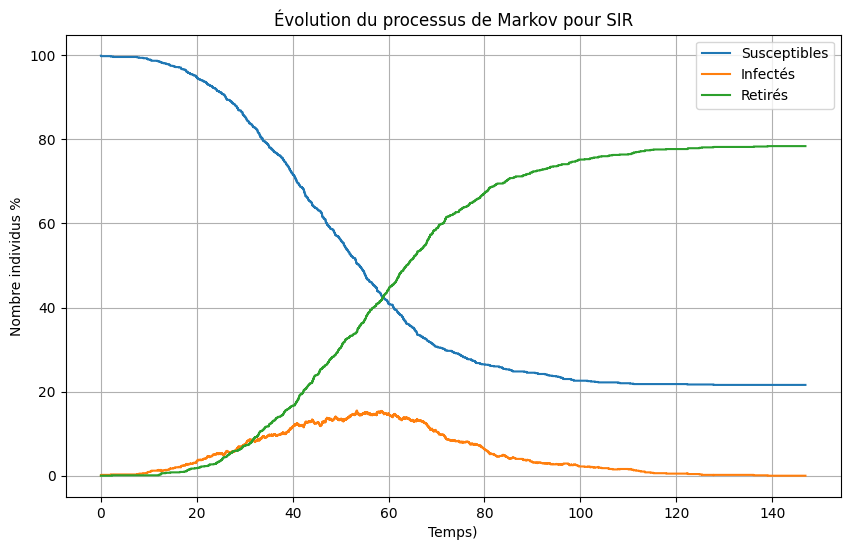

In [83]:
#Meme parametres que pour la simulation SIR
N_pop = 1000       
beta = 0.2     # Taux de transmission
gamma = 0.1    # Taux de guérison
tps_model = 200  # Temps maximum

# Lance la simulation
t, S, I, R = simulation_MARKOV(N_pop, beta, gamma, tps_model)

# Plot du graph
plt.figure(figsize=(10,6))
plt.step(t, (S/N_pop)*100, label='Susceptibles')
plt.step(t, (I/N_pop)*100, label='Infectés')
plt.step(t, (R/N_pop)*100, label='Retirés')
plt.xlabel('Temps)')
plt.ylabel('Nombre individus %')
plt.title('Évolution du processus de Markov pour SIR')
plt.legend()
plt.grid()
plt.show()

### 3) Analyse

Je dois trouver des couples de valeurs (beta, gamma) tels que 
- Tout le monde est retiré sur le long terme : donc tout le monde a été infecté puis guéri $\implies S = 0$
- il y a une partie de la population qui reste susceptible et une autre qui est retirée : donc plus d'épidémie mais reste des gens pas infectés $\implies S > 0$

Tout cela va dependre de $R_0$ car comme vue en cours :
- Plus $R_0$ est grand $\implies$ plus l'epidemie est forte  
- Plus $R_0$ est faible $\implies$ plus l'epidemie est faible donc petite partie d'infectés ($R_0$ < 1 $\implies$ tout le monde restesusceptible, l’épidémie ne démarre pas)

Dans le poly il est specifier :

$$1 − r_{\infty} = e^{(−R_0 r_{\infty})}$$

tel que $r_{\infty}$ représente la proportion finale de la population qui a été retirée

Apres plusieurs test, je trouve :
- $\beta = 0.2, \gamma = 0.1 \implies R_0 = 2$ donc $S > 0$ car $r_{\infty} < 1$
- $\beta = 1, \gamma = 0.05 \implies R_0 = 20$ donc  $S = 0$ car $r_{\infty} = 1$


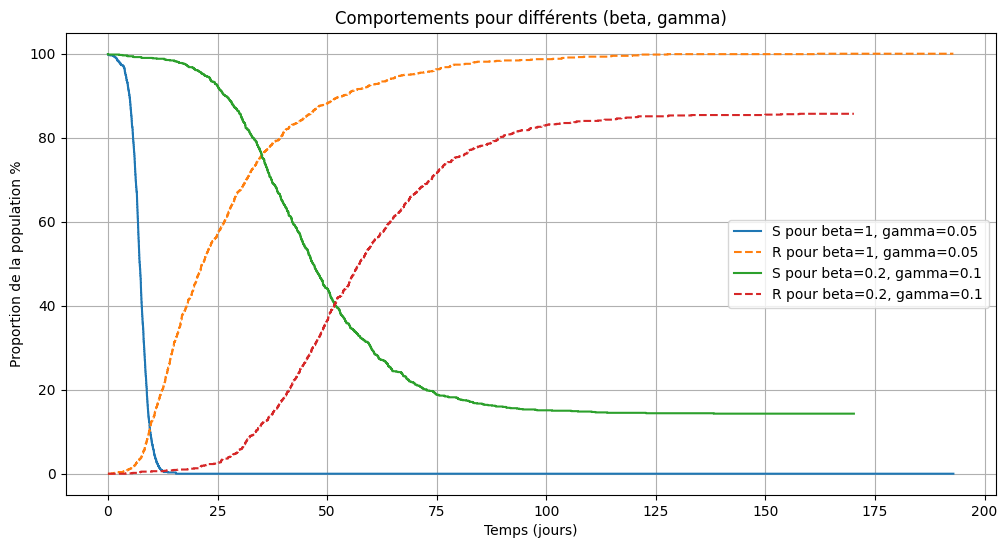

In [92]:
N_pop = 1000
tps_model = 200
couples = [
    (1, 0.05),  # R_0 = 20
    (0.2, 0.1),   # R_0 = 2
]

plt.figure(figsize=(12,6))

for beta, gamma in couples:
    t, S, I, R = simulation_MARKOV(N_pop, beta, gamma, tps_model)
    plt.step(t, (S/N_pop)*100, label=f"S pour beta={beta}, gamma={gamma}")
    plt.step(t, (R/N_pop)*100, linestyle='--', label=f"R pour beta={beta}, gamma={gamma}")

plt.xlabel('Temps (jours)')
plt.ylabel('Proportion de la population %')
plt.title('Comportements pour différents (beta, gamma)')
plt.legend()
plt.grid()
plt.show()


### 4) Convergence du processus de Markov

Pour montrer la convergence du modèle de Markov, je vais prendre les mêmes paramètres et je vais ploter les 2 simulations sur le même graphe pour voir s'il y a des différences.
Voici le code et le résultat ci-dessous :

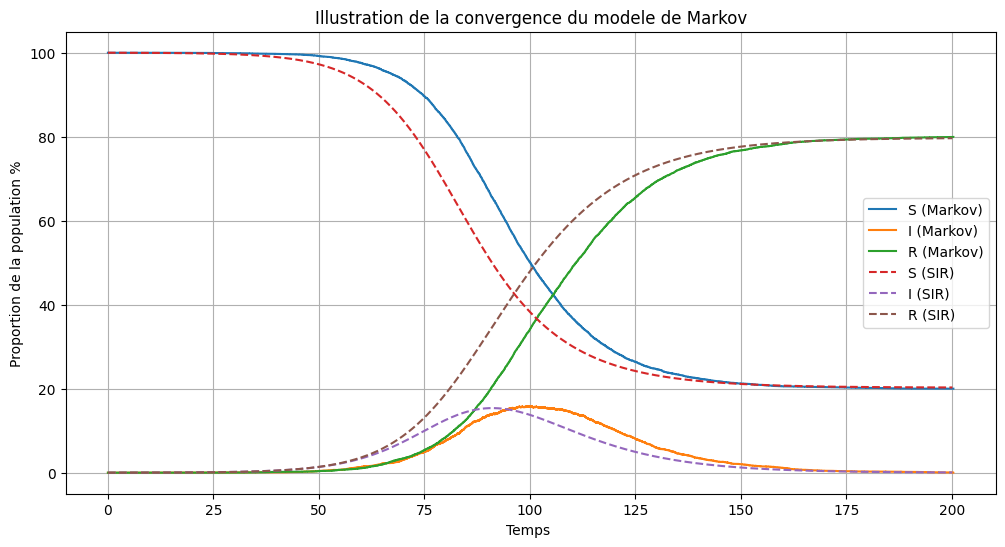

In [98]:

N_pop = 10000 
beta = 0.2
gamma = 0.1
tps_model = 200
dt = 0.1 

#Simulation SIR deterministe
t_sir, S_sir, I_sir, R_sir = sir_model(N_pop, beta, gamma, tps_model, dt)
#Simulation via modele de MARKOV
t_markov, S_markov, I_markov, R_markov = simulation_MARKOV(N_pop, beta, gamma, tps_model)


# Tracé
plt.figure(figsize=(12,6))

# Plot de Markov
plt.step(t_markov, (S_markov/N_pop)*100, label="S (Markov)", where='post')
plt.step(t_markov, (I_markov/N_pop)*100, label="I (Markov)", where='post')
plt.step(t_markov, (R_markov/N_pop)*100, label="R (Markov)", where='post')
# Plot de Sir
plt.plot(t_sir, (S_sir/N_pop)*100, '--', label="S (SIR)")
plt.plot(t_sir, (I_sir/N_pop)*100, '--', label="I (SIR)")
plt.plot(t_sir, (R_sir/N_pop)*100, '--', label="R (SIR)")

plt.xlabel('Temps ')
plt.ylabel('Proportion de la population %')
plt.title('Illustration de la convergence du modele de Markov')
plt.legend()
plt.grid()
plt.show()
